# Imports

In [1]:
try:
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN
    print("Library is already installed.")
except ImportError:
    print("Library is not installed. Proceed with installation.")
    !pip install fancyimpute
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="'verbose' argument is deprecated.*")

Library is already installed.


### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
df_data.isna().sum()

author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64

In [5]:
df_og.isna().sum()

author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns. The original data could be very he puff for that purpose since it does not contain any missing values.

In [6]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [7]:
df_data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [8]:
df_og.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


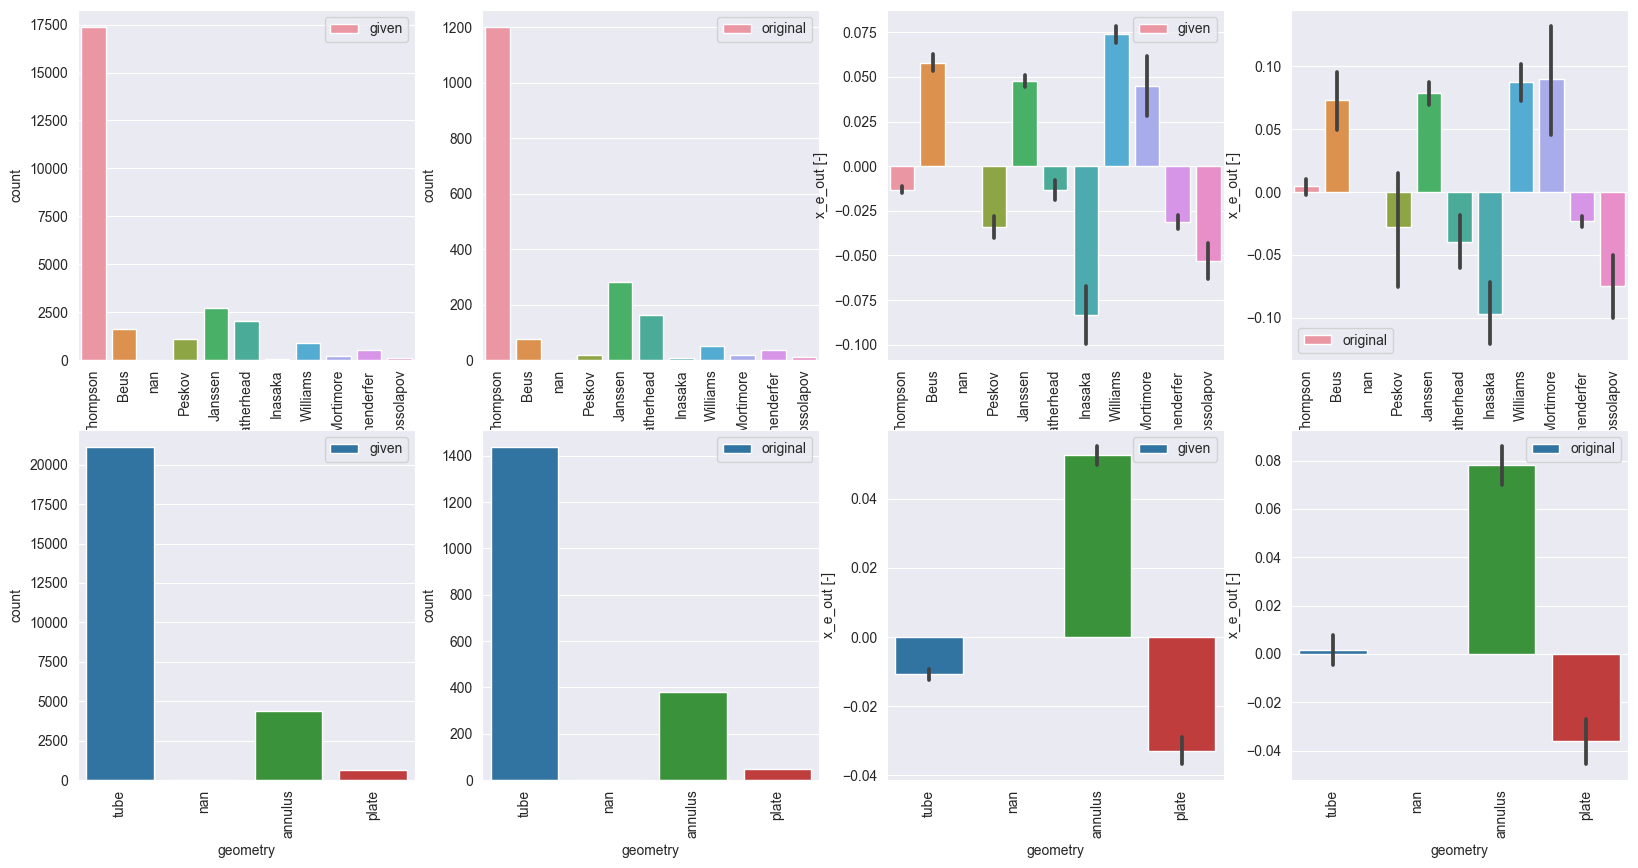

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Makes sure that the categories are shown in the same order
    category_order: list[str] = data[0][0][data[0][1]].unique()

    # Plot barplots
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.countplot(x=column, data=df, label=label, order=category_order, ax=axes[axes_start_i + il])
        axes[axes_start_i + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot target correlation
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.barplot(x=column, y=target, data=df, label=label, order=category_order, ax=axes[axes_start_i + 2 + il])
        axes[axes_start_i + 2 + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels


    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 2].legend()
    axes[axes_start_i + 3].legend()

i = 0
for col in df_data.columns:
    if not pd.api.types.is_numeric_dtype(df_data[col]):
        graph_categorical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
        i += 4

plt.show()

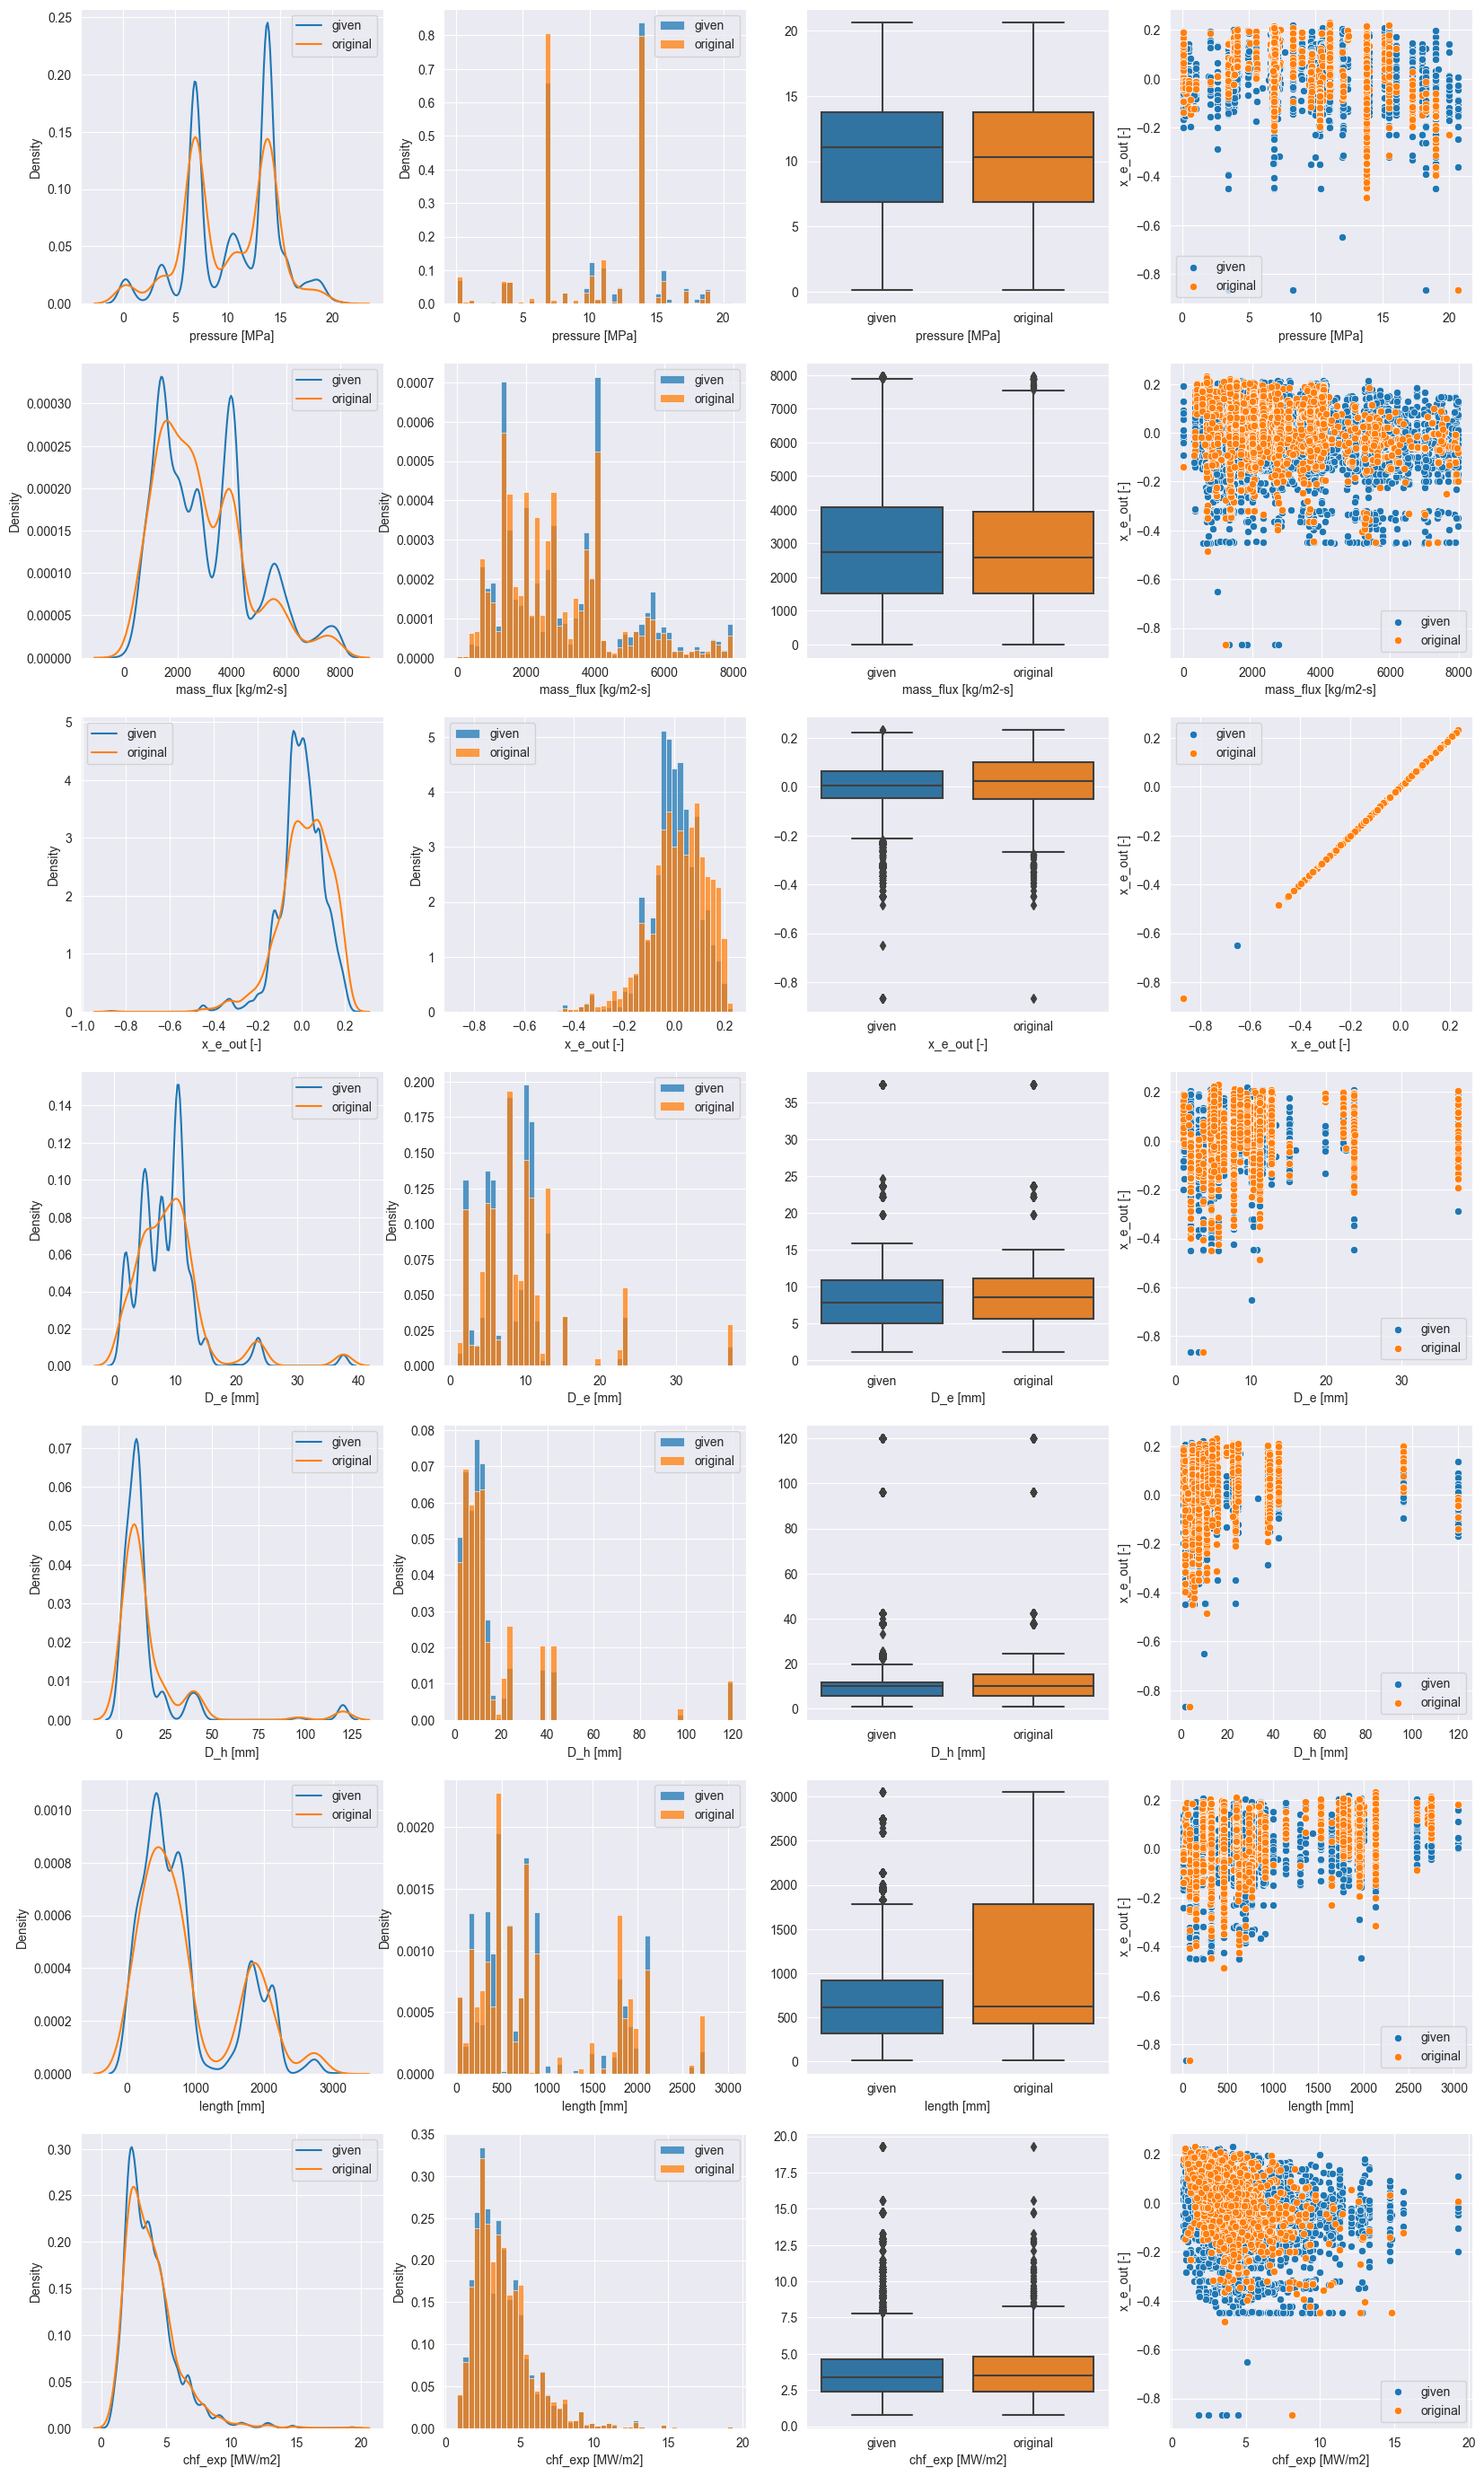

In [10]:
fig, axes = plt.subplots(nrows=len(df_data.columns) - 2, ncols=4, figsize=(20, 35))
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Plot densities
    for df, column, label in data:
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False)
    for df, column, label in data:
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50)

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2])
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for df, column, label in data:
        sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        graph_numerical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
        i += 4

plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

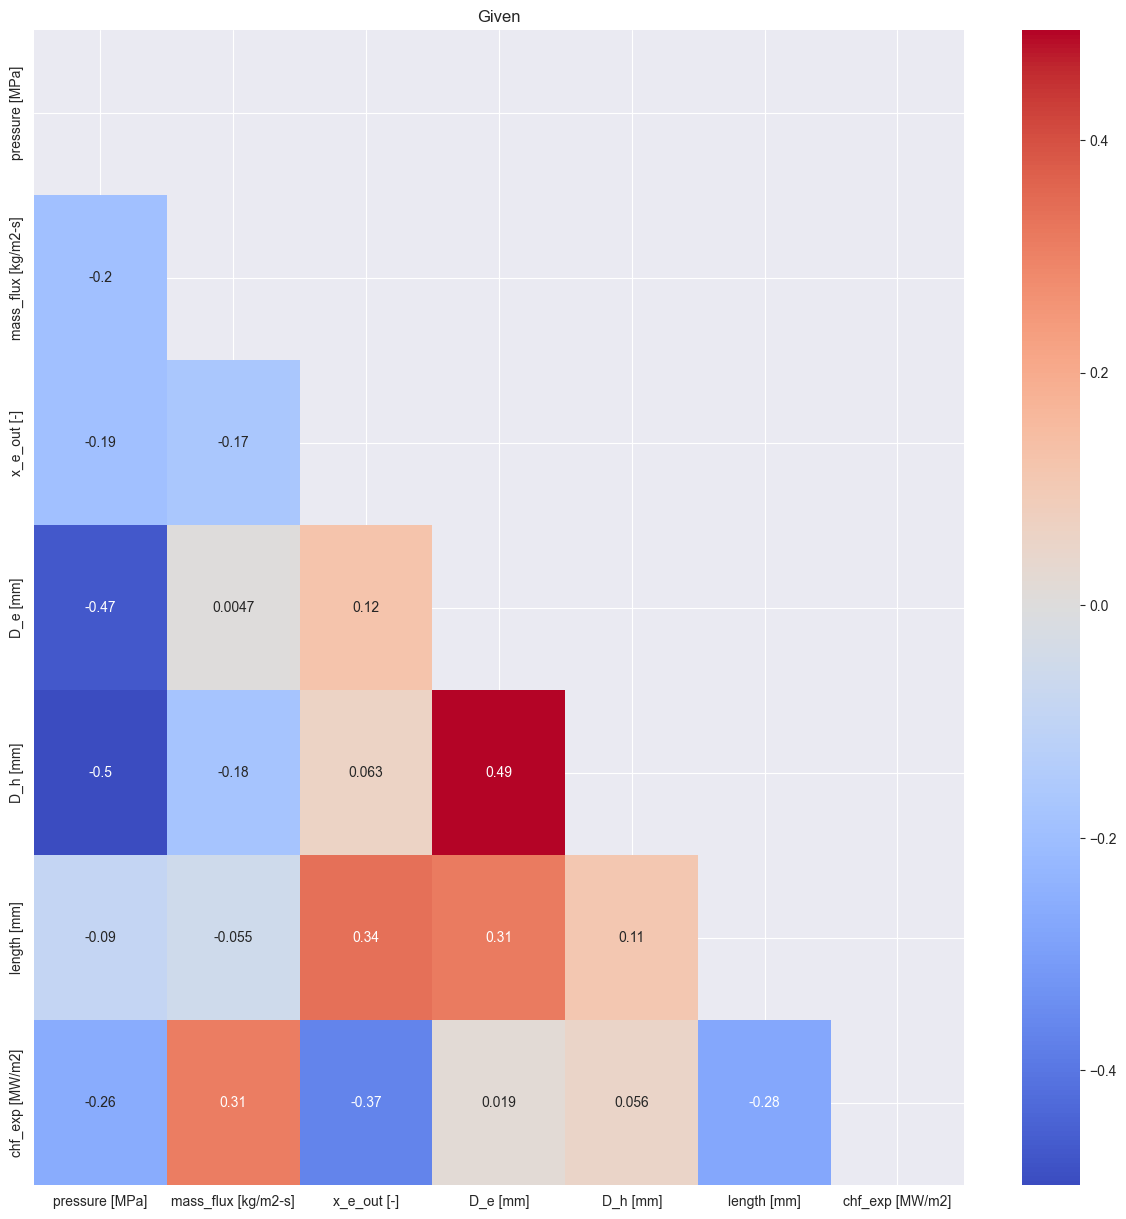

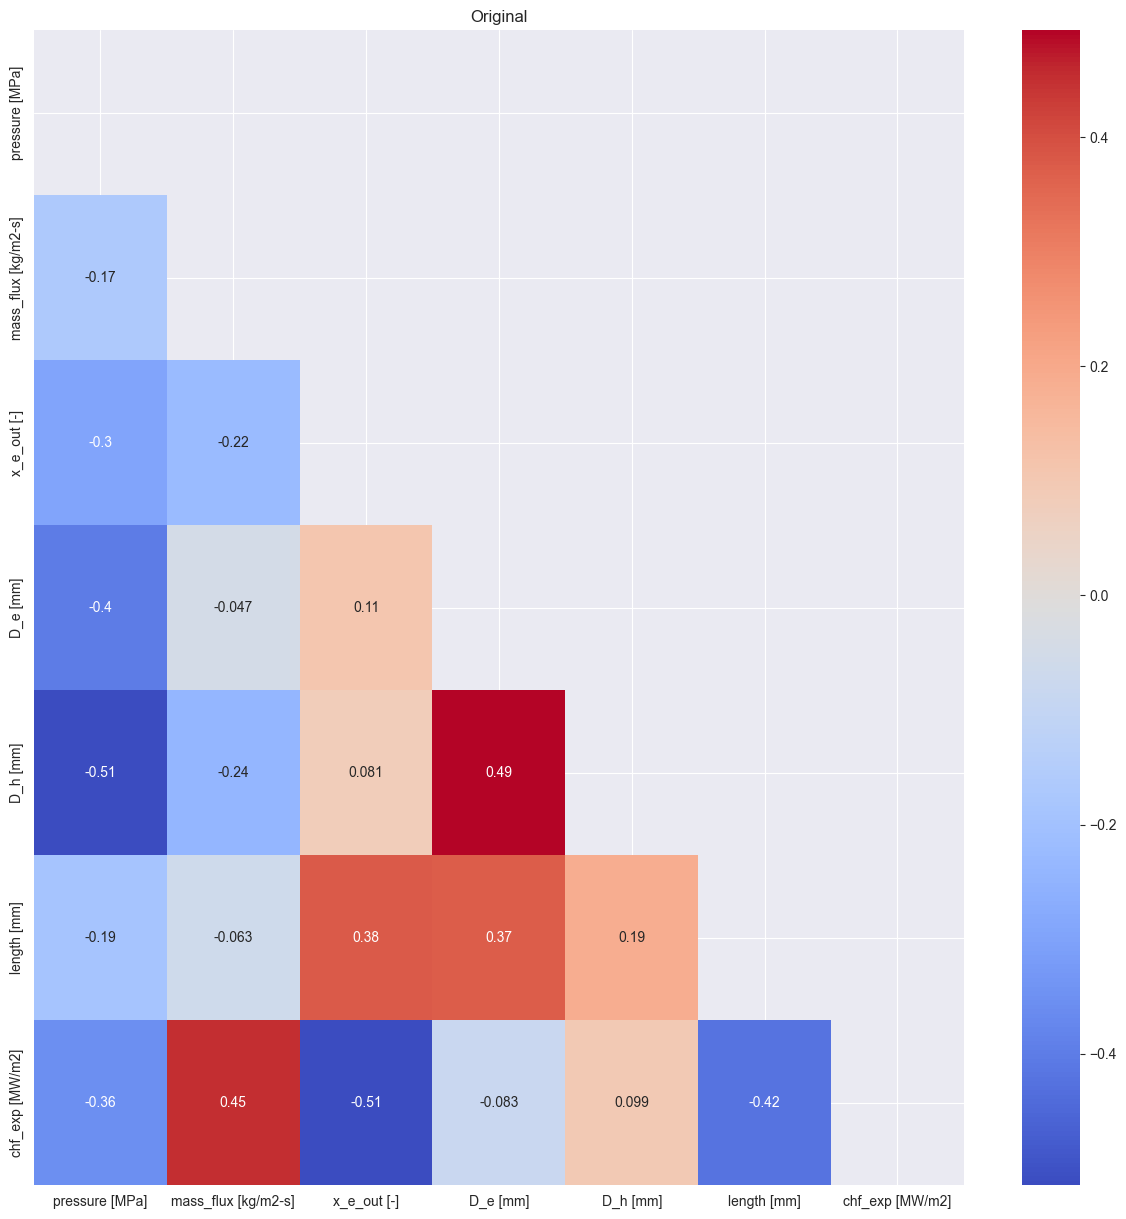

In [11]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(15, 15))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_data, "Given")
show_feature_correlation(df_og, "Original")

# Data Prep

In [12]:
numerical_columns = ['pressure [MPa]', 'mass_flux [kg/m2-s]','x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
numerical_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
categorical_columns = ['author', 'geometry']
target = 'x_e_out [-]'

In [13]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    for column in numerical_features:
        column_values = df[column].values  # No need to reshape column values
        not_nan_values = column_values[~pd.isnull(column_values)]  # Filter non-NaN values

        if not_nan_values.size > 0:  # Check if there are any non-NaN values
            not_nan_values = not_nan_values.reshape(-1, 1)  # Reshape to 2D array with single column
            standard_scaler = StandardScaler()
            normalized_values = standard_scaler.fit_transform(not_nan_values)

            # Create a mask to identify non-NaN values in the column
            mask = ~pd.isnull(df[column])
            # Replace the non-NaN values with normalized values in the original DataFrame
            df.loc[mask, column] = normalized_values.flatten()

    return df

In [14]:
df_train: pd.DataFrame = pd.concat([df_data, df_og])
df_train.reset_index(inplace=True, drop=True)

In [15]:
normalize(df_train)

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,Thompson,tube,-0.830902,0.404113,0.1754,NaN,-0.175731,-0.600507,-0.100901
1,Thompson,tube,NaN,1.691601,-0.0416,0.306885,-0.200815,-0.112494,-1.008131
2,Thompson,NaN,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,0.100706
3,Beus,annulus,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.856926
4,NaN,tube,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147
...,...,...,...,...,...,...,...,...,...
33504,Richenderfer,plate,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,-0.000098
33505,Richenderfer,plate,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,-0.151303
33506,Richenderfer,plate,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,-0.856926
33507,Richenderfer,plate,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,1.108739


In [16]:
#label_encode(df_train)

In [17]:
df_train = one_hot_encode(df_train)

In [18]:
df_train

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,-0.830902,0.404113,0.1754,NaN,-0.175731,-0.600507,-0.100901,0,0,0,0,0,0,0,1,0,0,0,0,1
1,NaN,1.691601,-0.0416,0.306885,-0.200815,-0.112494,-1.008131,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,0.100706,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.856926,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-1.512147,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,-0.000098,0,0,0,0,0,0,1,0,0,0,0,1,0
33505,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,-0.151303,0,0,0,0,0,0,1,0,0,0,0,1,0
33506,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,-0.856926,0,0,0,0,0,0,1,0,0,0,0,1,0
33507,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,1.108739,0,0,0,0,0,0,1,0,0,0,0,1,0


# Train

## Baseline 0: Impute all missing numerical value including target using MICE

In [19]:
# Create an instance of imputer
#imputer = IterativeSVD()
imputer = KNN()

# Perform the imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)
# Print the imputed DataFrame
print("Imputed DataFrame:")
df_train_imputed

Imputing row 1/33509 with 1 missing, elapsed time: 175.751
Imputing row 101/33509 with 3 missing, elapsed time: 176.188
Imputing row 201/33509 with 1 missing, elapsed time: 176.440
Imputing row 301/33509 with 1 missing, elapsed time: 176.729
Imputing row 401/33509 with 2 missing, elapsed time: 176.950
Imputing row 501/33509 with 1 missing, elapsed time: 176.992
Imputing row 601/33509 with 0 missing, elapsed time: 177.029
Imputing row 701/33509 with 1 missing, elapsed time: 177.066
Imputing row 801/33509 with 3 missing, elapsed time: 177.103
Imputing row 901/33509 with 3 missing, elapsed time: 177.132
Imputing row 1001/33509 with 0 missing, elapsed time: 177.170
Imputing row 1101/33509 with 2 missing, elapsed time: 177.206
Imputing row 1201/33509 with 2 missing, elapsed time: 177.242
Imputing row 1301/33509 with 1 missing, elapsed time: 177.281
Imputing row 1401/33509 with 0 missing, elapsed time: 177.317
Imputing row 1501/33509 with 0 missing, elapsed time: 177.355
Imputing row 1601/33

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,-0.830902,0.404113,0.175400,0.383767,-0.175731,-0.600507,-0.100901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.598193,1.691601,-0.041600,0.306885,-0.200815,-0.112494,-1.008131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.736130,-0.576615,0.033500,-0.186164,-0.331250,-0.563536,0.100706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.736130,0.352704,-0.027900,-0.584395,0.045006,1.916454,-0.856926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.736130,-1.338148,0.005072,0.458592,-0.160681,-0.563536,-1.512147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.021800,1.198165,5.302565,-1.224571,-0.000098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33505,-2.213306,-0.878291,-0.043400,1.198165,5.302565,-1.224571,-0.151303,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33506,-2.213306,-0.595823,-0.010900,1.198165,5.302565,-1.224571,-0.856926,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33507,-2.213306,-0.595823,-0.021800,1.198165,5.302565,-1.224571,1.108739,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
df_train_imputed.isna().sum()

pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
author_Beus            0
author_Inasaka         0
author_Janssen         0
author_Kossolapov      0
author_Mortimore       0
author_Peskov          0
author_Richenderfer    0
author_Thompson        0
author_Weatherhead     0
author_Williams        0
geometry_annulus       0
geometry_plate         0
geometry_tube          0
dtype: int64

## Baseline 1: Tree boosting on imputed data

### Construct new training data

In [21]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[f'{column}_was_an'] = df_train[column].isna().astype(int)

In [22]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[column] = df_train_imputed[column]

In [23]:
df_test = df_train[df_train[target].isna()]
df_train = df_train[~df_train[target].isna()]

In [24]:
def remove_special_characters(column_name):
    # Remove special characters using regular expressions
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    # Remove special characters from all column names in the DataFrame
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

df_test = remove_special_characters_from_dataframe(df_test)
df_train = remove_special_characters_from_dataframe(df_train)

#df_train = df_train[['mass_fluxkgm2s', 'pressureMPa', 'lengthmm', 'D_emm', 'D_hmm', 'chf_expMWm2', 'geometry_tube', 'x_e_out']]
#df_test = df_test[['mass_fluxkgm2s', 'pressureMPa', 'lengthmm', 'D_emm', 'D_hmm', 'chf_expMWm2', 'geometry_tube', 'x_e_out']]

In [25]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 250, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'num_leaves': trial.suggest_int('num_leaves', 3, 64),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm.best_params
best_mae = study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-20 20:01:18,725] A new study created in memory with name: no-name-8734e2e3-3b21-403b-9b9d-b8a337406d47
[I 2023-05-20 20:01:19,177] Trial 0 finished with value: 0.060277190584481305 and parameters: {'n_estimators': 465, 'max_depth': 8, 'num_leaves': 8, 'learning_rate': 0.02562486577470241, 'min_child_samples': 11, 'reg_alpha': 3.567217011633325, 'reg_lambda': 6.067696206914917, 'force_col_wise': True}. Best is trial 0 with value: 0.060277190584481305.
[I 2023-05-20 20:01:19,637] Trial 1 finished with value: 0.0604334721632468 and parameters: {'n_estimators': 1224, 'max_depth': 8, 'num_leaves': 33, 'learning_rate': 0.07594792629810186, 'min_child_samples': 20, 'reg_alpha': 9.884172789258905, 'reg_lambda': 3.7940262099091226, 'force_col_wise': True}. Best is trial 0 with value: 0.060277190584481305.
[I 2023-05-20 20:01:20,085] Trial 2 finished with value: 0.06046083685986273 and parameters: {'n_estimators': 1296, 'max_depth': 9, 'num_leaves': 58, 'learning_rate': 0.088673306623

Best Parameters: {'n_estimators': 1277, 'max_depth': 6, 'num_leaves': 13, 'learning_rate': 0.07224277242831857, 'min_child_samples': 19, 'reg_alpha': 2.022214127943049, 'reg_lambda': 1.3416258945757944, 'force_col_wise': False}
Best MAE: 0.059457900965078275


In [26]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_catboost.best_params
best_mae = study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-20 20:02:25,768] A new study created in memory with name: no-name-23a766d1-71b0-44fc-bbb7-d2fd9aa578f5
[I 2023-05-20 20:03:51,484] Trial 0 finished with value: 0.060909850288845255 and parameters: {'depth': 16, 'learning_rate': 0.19190129763380448, 'l2_leaf_reg': 0.2518471590350059, 'random_strength': 0.4179706374494909, 'bagging_temperature': 0.5625635602155596, 'grow_policy': 'SymmetricTree', 'iterations': 3726}. Best is trial 0 with value: 0.060909850288845255.
[I 2023-05-20 20:03:53,013] Trial 1 finished with value: 0.05863994981557867 and parameters: {'depth': 5, 'learning_rate': 0.18922831187112632, 'l2_leaf_reg': 0.027550783862843486, 'random_strength': 0.21657109552900067, 'bagging_temperature': 0.7128786919757909, 'grow_policy': 'Depthwise', 'iterations': 4994}. Best is trial 1 with value: 0.05863994981557867.
[I 2023-05-20 20:03:55,336] Trial 2 finished with value: 0.05844999047209139 and parameters: {'depth': 3, 'learning_rate': 0.10975093496391658, 'l2_leaf_reg':

Best Parameters: {'depth': 9, 'learning_rate': 0.02747746484557526, 'l2_leaf_reg': 0.3091737109840701, 'random_strength': 0.3328522341065729, 'bagging_temperature': 0.6059052983440882, 'grow_policy': 'Lossguide', 'iterations': 4290}
Best MAE: 0.05822247110115648


In [27]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        #'grow_policy': 'lossguide',
        'eta': trial.suggest_float('eta', 0.00, 1),
        'early_stopping_rounds': 100,
        'huber_slope': trial.suggest_float('huber_slope', 0.01, 1),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_xgboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost.optimize(objective, n_trials=1000)

# Print the best parameters and the best MAE
best_params = study_xgboost.best_params
best_mae = study_xgboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-20 20:18:36,828] A new study created in memory with name: no-name-fded5e4c-d59f-4581-b70f-5b05c817e908
[I 2023-05-20 20:18:37,031] Trial 0 finished with value: 0.2643432501657878 and parameters: {'n_estimators': 974, 'max_depth': 83, 'learning_rate': 0.05332223725551768, 'min_child_weight': 2.424673716392637, 'gamma': 0.6885333033245054, 'subsample': 0.5334691695994708, 'colsample_bytree': 0.9069364172467436, 'reg_alpha': 0.757382817372298, 'reg_lambda': 0.526070021101166, 'eta': 0.11417839110334471, 'huber_slope': 0.9476898085688733}. Best is trial 0 with value: 0.2643432501657878.
[I 2023-05-20 20:18:37,133] Trial 1 finished with value: 0.15335592076821514 and parameters: {'n_estimators': 548, 'max_depth': 52, 'learning_rate': 0.06169941192913911, 'min_child_weight': 3.6307660546009033, 'gamma': 0.5499872424995247, 'subsample': 0.7107182894356721, 'colsample_bytree': 0.6641328359589593, 'reg_alpha': 0.3707898644193566, 'reg_lambda': 0.322112586670946, 'eta': 0.502393563050

Best Parameters: {'n_estimators': 1850, 'max_depth': 88, 'learning_rate': 0.08941042647785143, 'min_child_weight': 6.476935982887756, 'gamma': 0.15099895365740185, 'subsample': 0.788857316261716, 'colsample_bytree': 0.9396324665945608, 'reg_alpha': 0.5706539440425857, 'reg_lambda': 0.594196561885292, 'eta': 0.6995012214582591, 'huber_slope': 0.14869400869989188}
Best MAE: 0.06810536977170562


In [28]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**study_lgbm.best_params)
        elif model_type == 'CatBoost':
            self.model = CatBoostRegressor(**study_catboost.best_params)
        elif model_type == 'XGBoost':
            self.model = xgb.XGBRegressor(**study_xgboost.best_params)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['CatBoost']:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], early_stopping_rounds=500, verbose=False)
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [29]:
def train(model_type):
    X = df_train.drop(['x_e_out'], axis=1)
    y = df_train['x_e_out']
    SKFs = KFold(n_splits=10, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('x_e_out', axis=1)
        y_train = train_dataframe['x_e_out']
        X_dev = dev_dataframe.drop('x_e_out', axis=1)
        y_dev = dev_dataframe['x_e_out']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [30]:
supported_models = ['LightGBM', 'CatBoost', 'XGBoost']

In [31]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

-------------------- LightGBM -------------------- 
Fold 0 loss: 0.05979812308980726
Fold 1 loss: 0.05996529471955838
Fold 2 loss: 0.061000414542898666
Fold 3 loss: 0.06068775941666978
Fold 4 loss: 0.058999348209580534
Fold 5 loss: 0.05803841708868373
Fold 6 loss: 0.0586668290104307
Fold 7 loss: 0.05998219365505173
Fold 8 loss: 0.059725269500658054
Fold 9 loss: 0.059006540933220344
Mean loss: 0.05958701901665592
-------------------- CatBoost -------------------- 
Fold 0 loss: 0.059692256115292115
Fold 1 loss: 0.060050581753113445
Fold 2 loss: 0.06112871356675375
Fold 3 loss: 0.06087730435664891
Fold 4 loss: 0.05872503007601675
Fold 5 loss: 0.05834256605930772
Fold 6 loss: 0.059073321323590965
Fold 7 loss: 0.05998339270646308
Fold 8 loss: 0.05973195245729487
Fold 9 loss: 0.059515108994798484
Mean loss: 0.05971202274092802
-------------------- XGBoost -------------------- 
Fold 0 loss: 0.06033287078285925
Fold 1 loss: 0.0603537516422811
Fold 2 loss: 0.06129579310850898
Fold 3 loss: 0.061

## Calculate assembly weights

In [32]:
model_predictions_on_validation = {'model_name': [], 'x': [], 'y': []}
def calc_model_predictions_on_validation(pipelines, eval_sets_idx):
    predictions = None
    ground_truth = None

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        if predictions is None:
            predictions = np.array(prediction).flatten()
            ground_truth = np.array(y_dev).flatten()
        else:
            predictions = np.concatenate((predictions,  np.array(prediction).flatten()))
            ground_truth = np.concatenate((ground_truth,  np.array(y_dev).flatten()))

    model_predictions_on_validation['model_name'].append(model_name)
    model_predictions_on_validation['x'].append(predictions)
    model_predictions_on_validation['y'].append(ground_truth) # Should be the same for all models

for model_name in supported_models:
    calc_model_predictions_on_validation(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets'])

In [33]:
def eval_assembly_on_validation(weights):
    #weights = weights / np.sum(weights, axis=0, keepdims=True)
    prediction = 0

    for model_id, x in enumerate(model_predictions_on_validation['x']):
        prediction += x * weights[model_id]

    return mean_absolute_error(model_predictions_on_validation['y'][0], prediction)

In [34]:
# Set initial weights
model_weights = np.array([0.25, 0.25, 0.25, 0.25])
# Define the optimization bounds
bounds = [(0, 1.0)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())

0.9243721570354785
1.0


In [35]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(model_predictions_on_validation['model_name'])):
    df_optimal_model_weights['model_name'].append(model_predictions_on_validation['model_name'][i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {model_predictions_on_validation['model_name'][i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

0.703 LightGBM
0.290 CatBoost
0.000 XGBoost


In [36]:
performance_data = {'model_name': [], 'training_loss': [], 'og_data_excluded': []}
def get_loss(pipelines, eval_sets_idx):
    losses = []

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        loss = mean_absolute_error(y_dev, prediction)
        losses.append(loss)

    return np.array(losses).mean()

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['training_loss'].append(np.array(train_results[f'{model_name}_losses']).mean())
    performance_data['og_data_excluded'].append(get_loss(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets']))
performance_data = pd.DataFrame(performance_data)

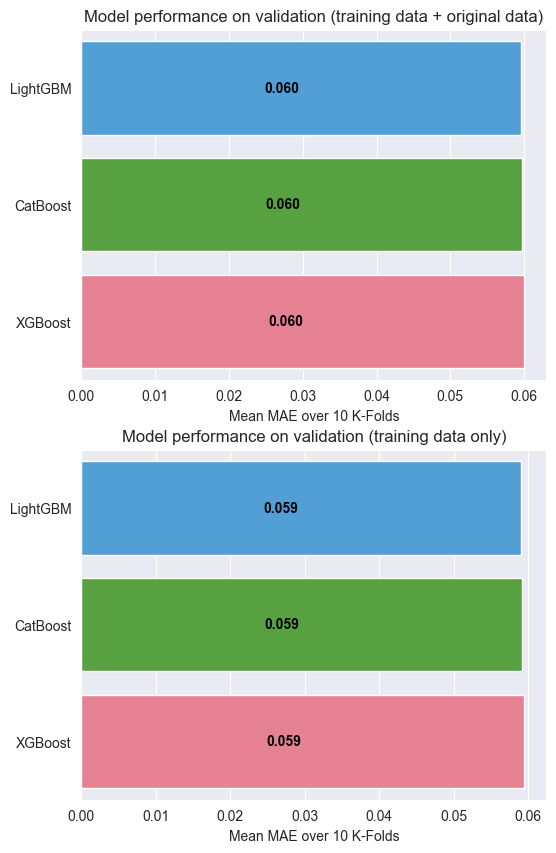

In [37]:
loss_eval_types: list[str] = ['training_loss', 'og_data_excluded']
fig, axes = plt.subplots(nrows=len(loss_eval_types), ncols=1, figsize=(6, 10))
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]
titles = ['Model performance on validation (training data + original data)',
          'Model performance on validation (training data only)']

for ax_index, loss_eval_type in enumerate(loss_eval_types):
    performance_data.sort_values(loss_eval_type, ascending=True, inplace=True)
    sns.barplot(x=loss_eval_type, y='model_name', data=performance_data, ax=axes[ax_index], palette=palette_reversed)
    for i, v in enumerate(performance_data[loss_eval_type]):
        axes[ax_index].text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    axes[ax_index].set(ylabel=None)
    axes[ax_index].set(xlabel="Mean MAE over 10 K-Folds")
    axes[ax_index].set_title(titles[ax_index])
plt.show()

In [38]:
performance_data

,model_name,training_loss,og_data_excluded
0,LightGBM,0.059587,0.059090
1,CatBoost,0.059712,0.059238
2,XGBoost,0.060015,0.059477


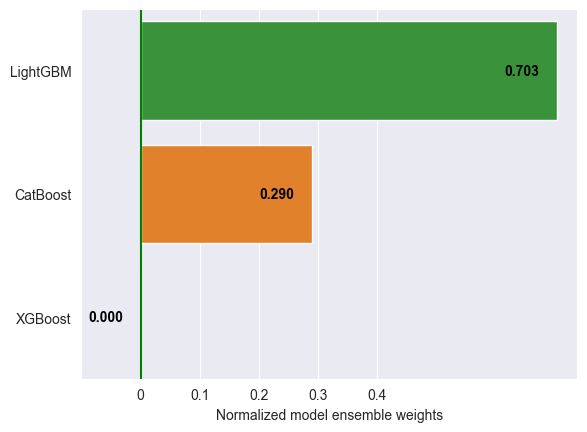

In [39]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights)
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

# Feature Importance

In [40]:
def make_predictions(x):
    prediction = 0

    #for model_id in range(len(supported_models)):
    #    for pipeline in train_results[f'{supported_models[model_id]}_pipelines']:
    #        prediction += np.array(pipeline.predict(x)).flatten() * optimal_model_weights[model_id] * 0.2
    model_name_to_use = 'XGBoost'
    for pipeline in train_results[f'{model_name_to_use}_pipelines']:
        prediction += np.array(pipeline.predict(x)).flatten()
    prediction = prediction / float(len(train_results[f'{model_name_to_use}_pipelines']))

    return prediction

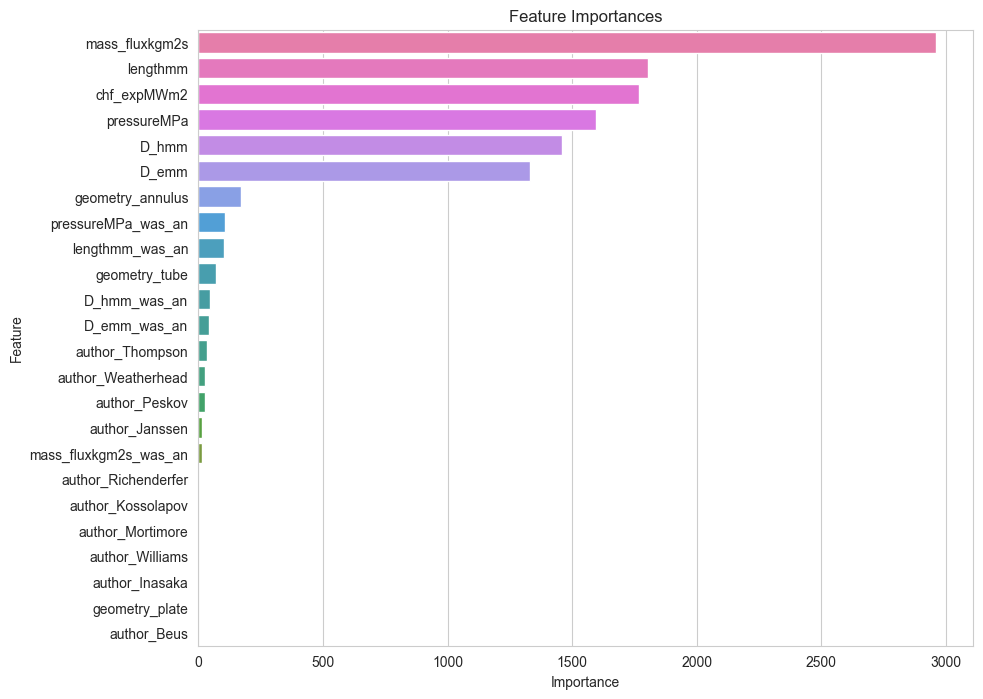

In [41]:
# Get feature importance
importance = train_results['LightGBM_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_pipelines'])):
    importance += train_results['LightGBM_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('x_e_out', axis=1).columns.values

# Create a dataframe of feature importance
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
# Sort features by importance
df_importance = df_importance.sort_values('importance', ascending=False)

# Create horizontal bar plot of feature importance
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [42]:
def get_split_data(eval_sets_idx) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_all_data: pd.DataFrame = None
    for eval_set in eval_sets_idx:
        if df_all_data is None:
            df_all_data = df_train.iloc[eval_set]
        else:
            df_all_data = pd.concat([df_all_data, df_train.iloc[eval_set]])

    df_eval_given: pd.DataFrame = df_all_data[df_all_data.index < len(df_data)]
    df_eval_original: pd.DataFrame = df_all_data[df_all_data.index >= len(df_data)]

    return df_eval_given, df_eval_original

In [43]:
def graph_predictions_vs_true() -> None:
    # All model should have the exact same eval sets
    df_eval_given, df_eval_original = get_split_data(train_results['LightGBM_eval_sets'])

    graph_data = {
        "data": [df_eval_given, df_eval_original],
        "name": ['given', 'original']
    }

    for data, name in zip(graph_data['data'], graph_data['name']):
        X = data.drop('x_e_out', axis=1)
        y = data['x_e_out']
        y_predicted = make_predictions(X)
        data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
        sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
    plt.title("True vs Predicted")
    plt.legend()

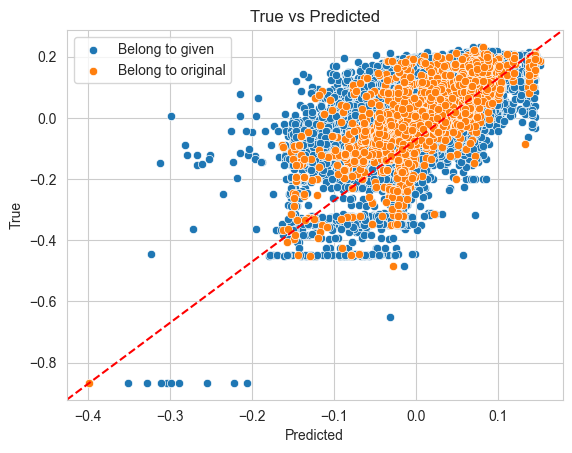

In [44]:
graph_predictions_vs_true()

# Make predictions

In [45]:
df_test = df_test.drop('x_e_out', axis=1)

In [46]:
predictions = make_predictions(df_test)

In [47]:
df_test['x_e_out [-]'] = predictions

In [48]:
df_test['x_e_out [-]'].to_csv("submission.csv", index=True, index_label='id')